In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# tensorflow version
tf.__version__

'2.12.0'

# Data Pre-processing

## Download data

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE
                                                            )

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


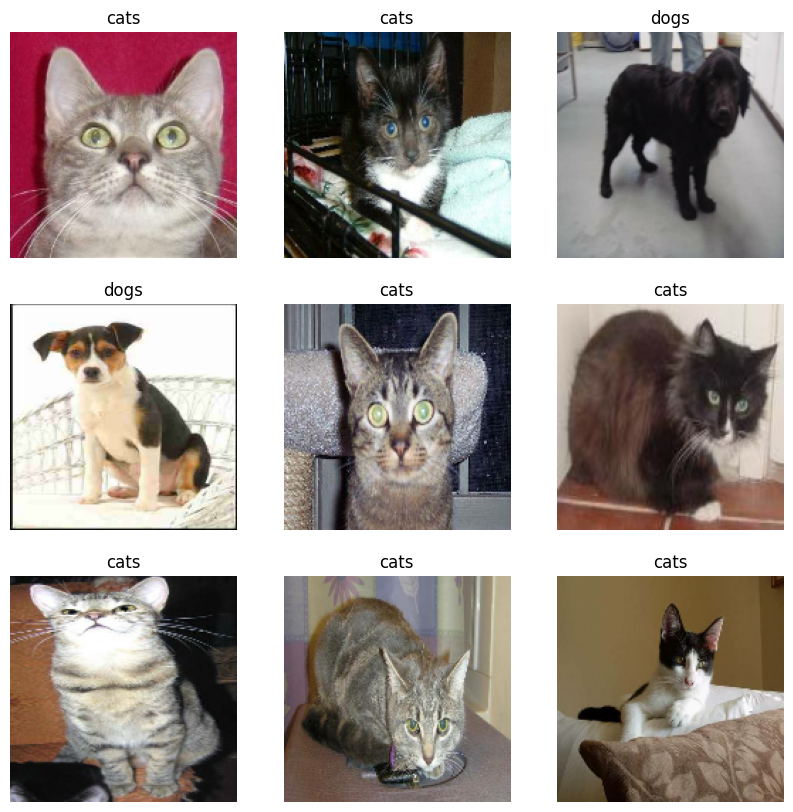

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create test set

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

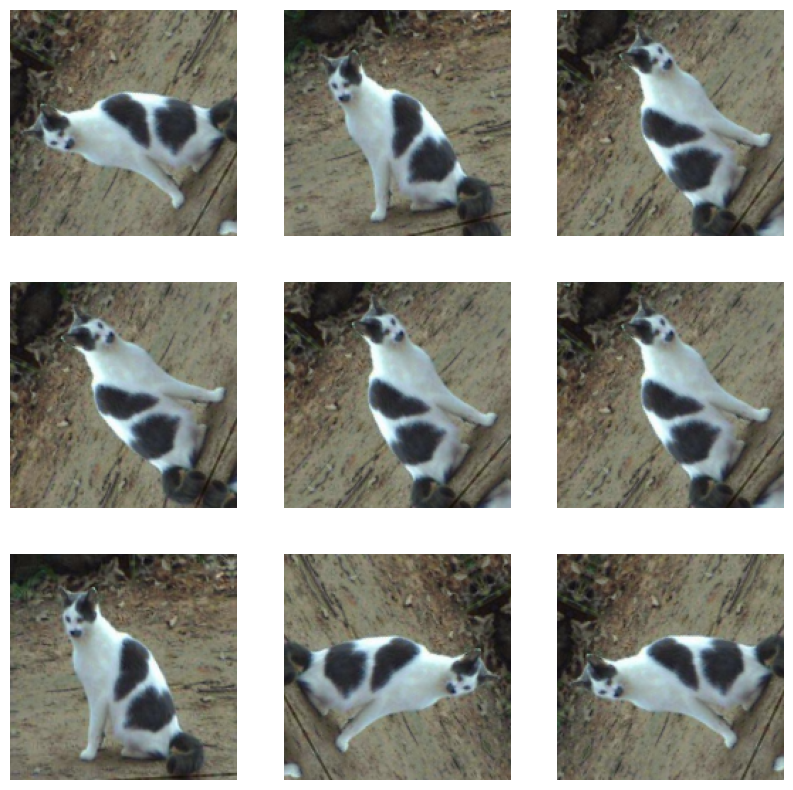

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [11]:
# using mobilenet's preprocess method
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# using tf's layer
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base model from the pre-trained convnets

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# 1. Transfer Learning

In [16]:
base_model.trainable = False

## Add a classification head

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Chain together various steps for the new model build for cat vs dog classification

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## Compile and train the model

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 12s 387ms/step - loss: 0.7246 - accuracy: 0.5545


In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 41s 565ms/step - loss: 0.6923 - accuracy: 0.6035 - val_loss: 0.4989 - val_accuracy: 0.7698
Epoch 2/10
63/63 [==============================] - 36s 573ms/step - loss: 0.5110 - accuracy: 0.7620 - val_loss: 0.3639 - val_accuracy: 0.8787
Epoch 3/10
63/63 [==============================] - 37s 579ms/step - loss: 0.4166 - accuracy: 0.8225 - val_loss: 0.2966 - val_accuracy: 0.9022
Epoch 4/10
63/63 [==============================] - 35s 557ms/step - loss: 0.3470 - accuracy: 0.8700 - val_loss: 0.2453 - val_accuracy: 0.9332
Epoch 5/10
63/63 [==============================] - 37s 586ms/step - loss: 0.2989 - accuracy: 0.8865 - val_loss: 0.2062 - val_accuracy: 0.9431
Epoch 6/10
63/63 [==============================] - 36s 569ms/step - loss: 0.2693 - accuracy: 0.9030 - val_loss: 0.1933 - val_accuracy: 0.9381
Epoch 7/10
63/63 [==============================] - 36s 575ms/step - loss: 0.2559 - accuracy: 0.9070 - val_loss: 0.1689 - val_accuracy: 0.9505

### Learning Curves

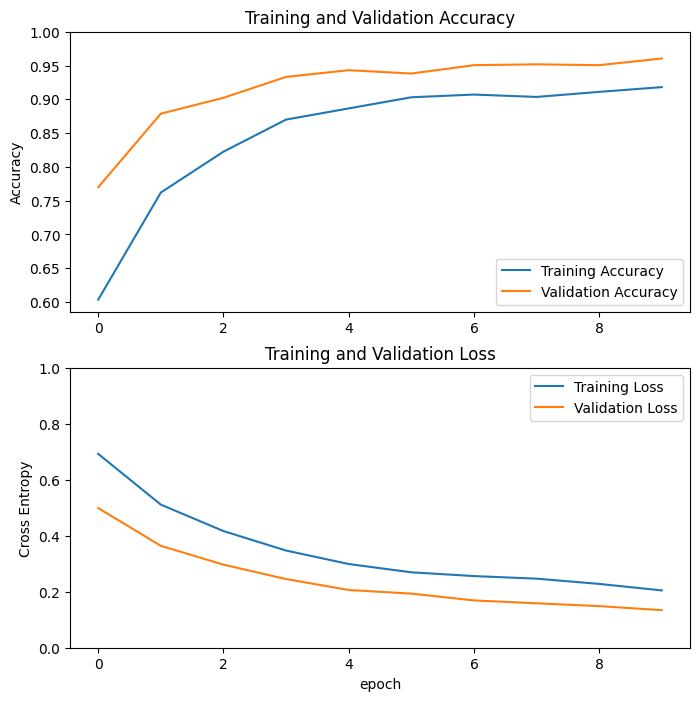

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Fine Tuning

## Unfreeze top layers of the model

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [27]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Compile the model

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
len(model.trainable_variables)


56

## Continue training the model

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 57s 792ms/step - loss: 0.1590 - accuracy: 0.9390 - val_loss: 0.0930 - val_accuracy: 0.9579
Epoch 11/20
63/63 [==============================] - 48s 755ms/step - loss: 0.1266 - accuracy: 0.9450 - val_loss: 0.0567 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 49s 779ms/step - loss: 0.1120 - accuracy: 0.9560 - val_loss: 0.0576 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 49s 771ms/step - loss: 0.0984 - accuracy: 0.9605 - val_loss: 0.0463 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 48s 759ms/step - loss: 0.0902 - accuracy: 0.9655 - val_loss: 0.0455 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 48s 758ms/step - loss: 0.0854 - accuracy: 0.9680 - val_loss: 0.0408 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 49s 783ms/step - loss: 0.0797 - accuracy: 0.9710 - val_loss: 0.0398 - val_accuracy:

## Learning curves for fine tuning

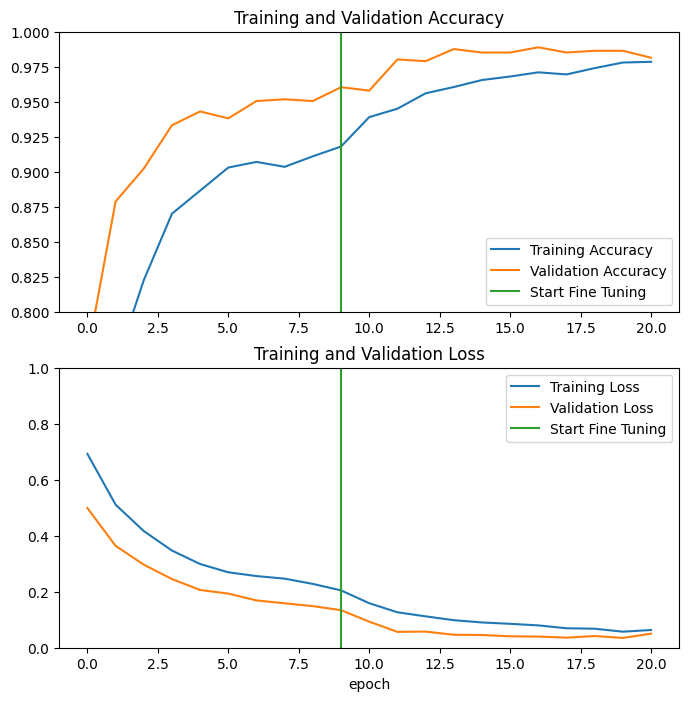

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation and Prediciton

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 373ms/step - loss: 0.0809 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Predictions:
 [0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0]
Labels:
 [0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0]


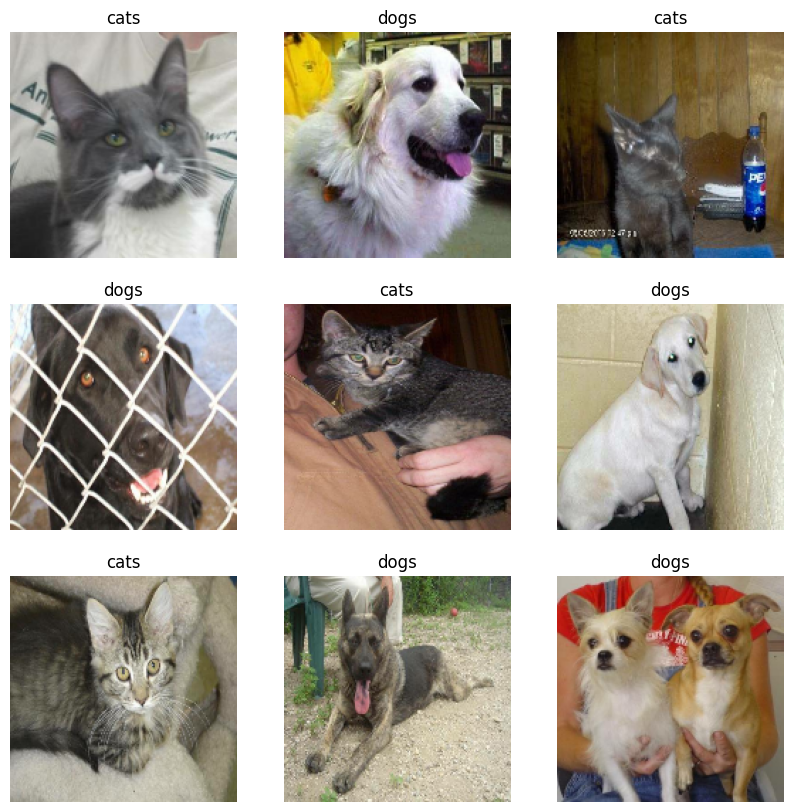

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")